## Imports

In [1]:
# Import packages
import pandas as pd
import numpy as np

import scipy.stats as stats
import pingouin as pg

import random
from random import randrange

import matplotlib.pyplot as plt
import seaborn as sns

import Orthoscripts

pd.options.mode.chained_assignment = None 

#### Import genelists

In [2]:
# Asterias rubens
Astrub = Orthoscripts.readBED("Data/Genelists/Asterias.rubens.genelist.bed")

# Holothuria leucospilota
Holleu = Orthoscripts.readBED("Data/Genelists/Holothuria.leucospilota.genelist.bed")

# Paracentrotus livides
Parliv = Orthoscripts.readBED("Data/Genelists/Paracentrotus.lividus.genelist.bed")

# Branchiostoma lanceolatum
Bralan = Orthoscripts.readBED("Data/Genelists/Branchiostoma.lanceolatum.genelist.bed")

# Branchiostoma floridae
Braflo = Orthoscripts.readBED("Data/Genelists/Branchiostoma.floridae.genelist.bed", 's')

# Marthasterias glacialis
Margla = Orthoscripts.readBED("Data/Genelists/Marthasterias.glacialis.genelist.bed")

# Pecten maximus
Pecmax = Orthoscripts.readBED("Data/Genelists/Pecmax.genelist.bed", 's')

# Stichopus chloronotus
Stichl = Orthoscripts.readBED("Data/Genelists/Stichopus.chloronotus.genelist.bed")

# Amphiura filiformis 
Ampfil = Orthoscripts.readBED("Data/Genelists/Amphiura.filiformis.genelist.bed")

# Ephydatia muelleri
Ephmue = Orthoscripts.readBED("Data/Genelists/Ephmue.genelist.bed", 's')

# Ancestor 
AniAnc = Orthoscripts.readBED("Data/Genelists/AniAnc.genelist.bed", 's')
BilAnc = Orthoscripts.readBED("Data/Genelists/BilAnc.genelist.bed", 's')

#### Import ortholog files

In [3]:
# Import orthologs
Astrub_Holleu = np.loadtxt("Data/Orthologs/Asterias.rubens+Holothuria.leucospilota.txt", dtype = "str")

Astrub_Parliv = np.loadtxt("Data/Orthologs/Asterias.rubens+Paracentrotus.lividus.txt", dtype = "str")

Holleu_Parliv = np.loadtxt("Data/Orthologs/Holothuria.leucospilota+Paracentrotus.lividus.txt", dtype = "str")

Margla_Bralan = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Branchiostoma.lanceolatum.txt", dtype = "str")

Margla_Pecmax = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Pecten.maximus.txt", dtype = "str")

Margla_Stichl = np.loadtxt("Data/Orthologs/Marthasterias.glacialis+Stichopus.chloronotus.txt", dtype = "str")

Pecmax_Bralan = np.loadtxt("Data/Orthologs/Pecten.maximus+Branchiostoma.lanceolatum.txt", dtype = "str")

Stichl_Bralan = np.loadtxt("Data/Orthologs/Stichopus.chloronotus+Branchiostoma.lanceolatum.txt", dtype = "str")

Stichl_Pecmax = np.loadtxt("Data/Orthologs/Stichopus.chloronotus+Pecten.maximus.txt", dtype = "str")

Pecmax_Holleu = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Holleu_sensitive.txt", dtype = "str")

Holleu_Bralan = np.loadtxt("Orthology pipeline/orthologs/Holleu+Bralan_sensitive.txt", dtype = "str")

Pecmax_Bralan = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Bralan_sensitive.txt", dtype = "str")

Pecmax_Braflo = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Braflo_sensitive.txt", dtype = "str")

Holleu_Braflo = np.loadtxt("Orthology pipeline/orthologs/Holleu+Braflo_sensitive.txt", dtype = "str")

Holleu_Ampfil = np.loadtxt("Data/Orthologs/Holothuria.leucospilota+Amphiura.filiformis.txt", dtype = "str")

Braflo_Ephmue = np.loadtxt("Orthology pipeline/orthologs/Braflo+Ephmue_sensitive.txt", dtype = "str")

Holleu_Ephmue = np.loadtxt("Orthology pipeline/orthologs/Holleu+Ephmue_sensitive.txt", dtype = "str")

Pecmax_Ephmue = np.loadtxt("Orthology pipeline/orthologs/Pecmax+Ephmue_sensitive.txt", dtype = "str")

#### Sorting out the data

In [4]:
Astrub = Astrub.loc[Astrub['Chromosome'].str.contains('chr')]
Bralan = Bralan.loc[Bralan['Chromosome'].str.contains('BFL_')]
Braflo = Braflo.loc[Braflo['Chromosome'].str.contains('BFL_')]
Pecmax = Pecmax.loc[Pecmax['Chromosome'].str.contains('PYE_')]
Ephmue = Ephmue.loc[Ephmue['Chromosome'].str.contains('EMU_')]

# Ephmue genelist: remove suffix
Ephmue['Name'] = Ephmue['Name'].str.rsplit('.t1').str.get(0)

# Parliv genelist: select chromosomal scaffolds
Parliv = Orthoscripts.unscaff(Parliv, 100)
Ampfil = Orthoscripts.unscaff(Ampfil, 100)
Ephmue = Orthoscripts.unscaff(Ephmue, 600)

Astrub_Parliv = Orthoscripts.orthFix(Astrub_Parliv, 'B', 'Parliv_', 1)
Margla_Bralan = Orthoscripts.orthFix(Margla_Bralan, 'A', '.1', 0)
Margla_Stichl = Orthoscripts.orthFix(Margla_Stichl, 'A', '.1', 0)
Margla_Stichl = Orthoscripts.orthFix(Margla_Stichl, 'B', '.1', 0)
Margla_Pecmax = Orthoscripts.orthFix(Margla_Pecmax, 'B', '.1', 0)
Holleu_Ampfil = Orthoscripts.orthFix(Holleu_Ampfil, 'B', '.1', 0)
Holleu_Bralan = Orthoscripts.orthFix(Holleu_Bralan, 'B', '_', 0)

### 
-----

### Plots

In [ ]:
data = Orthoscripts.orthofind(Braflo, Ephmue, Braflo_Ephmue)
Orthoscripts.orthoplot(data, 'Amphioxus', 'Sponge', 'A', 'B')

------------------------------

### Test simulations

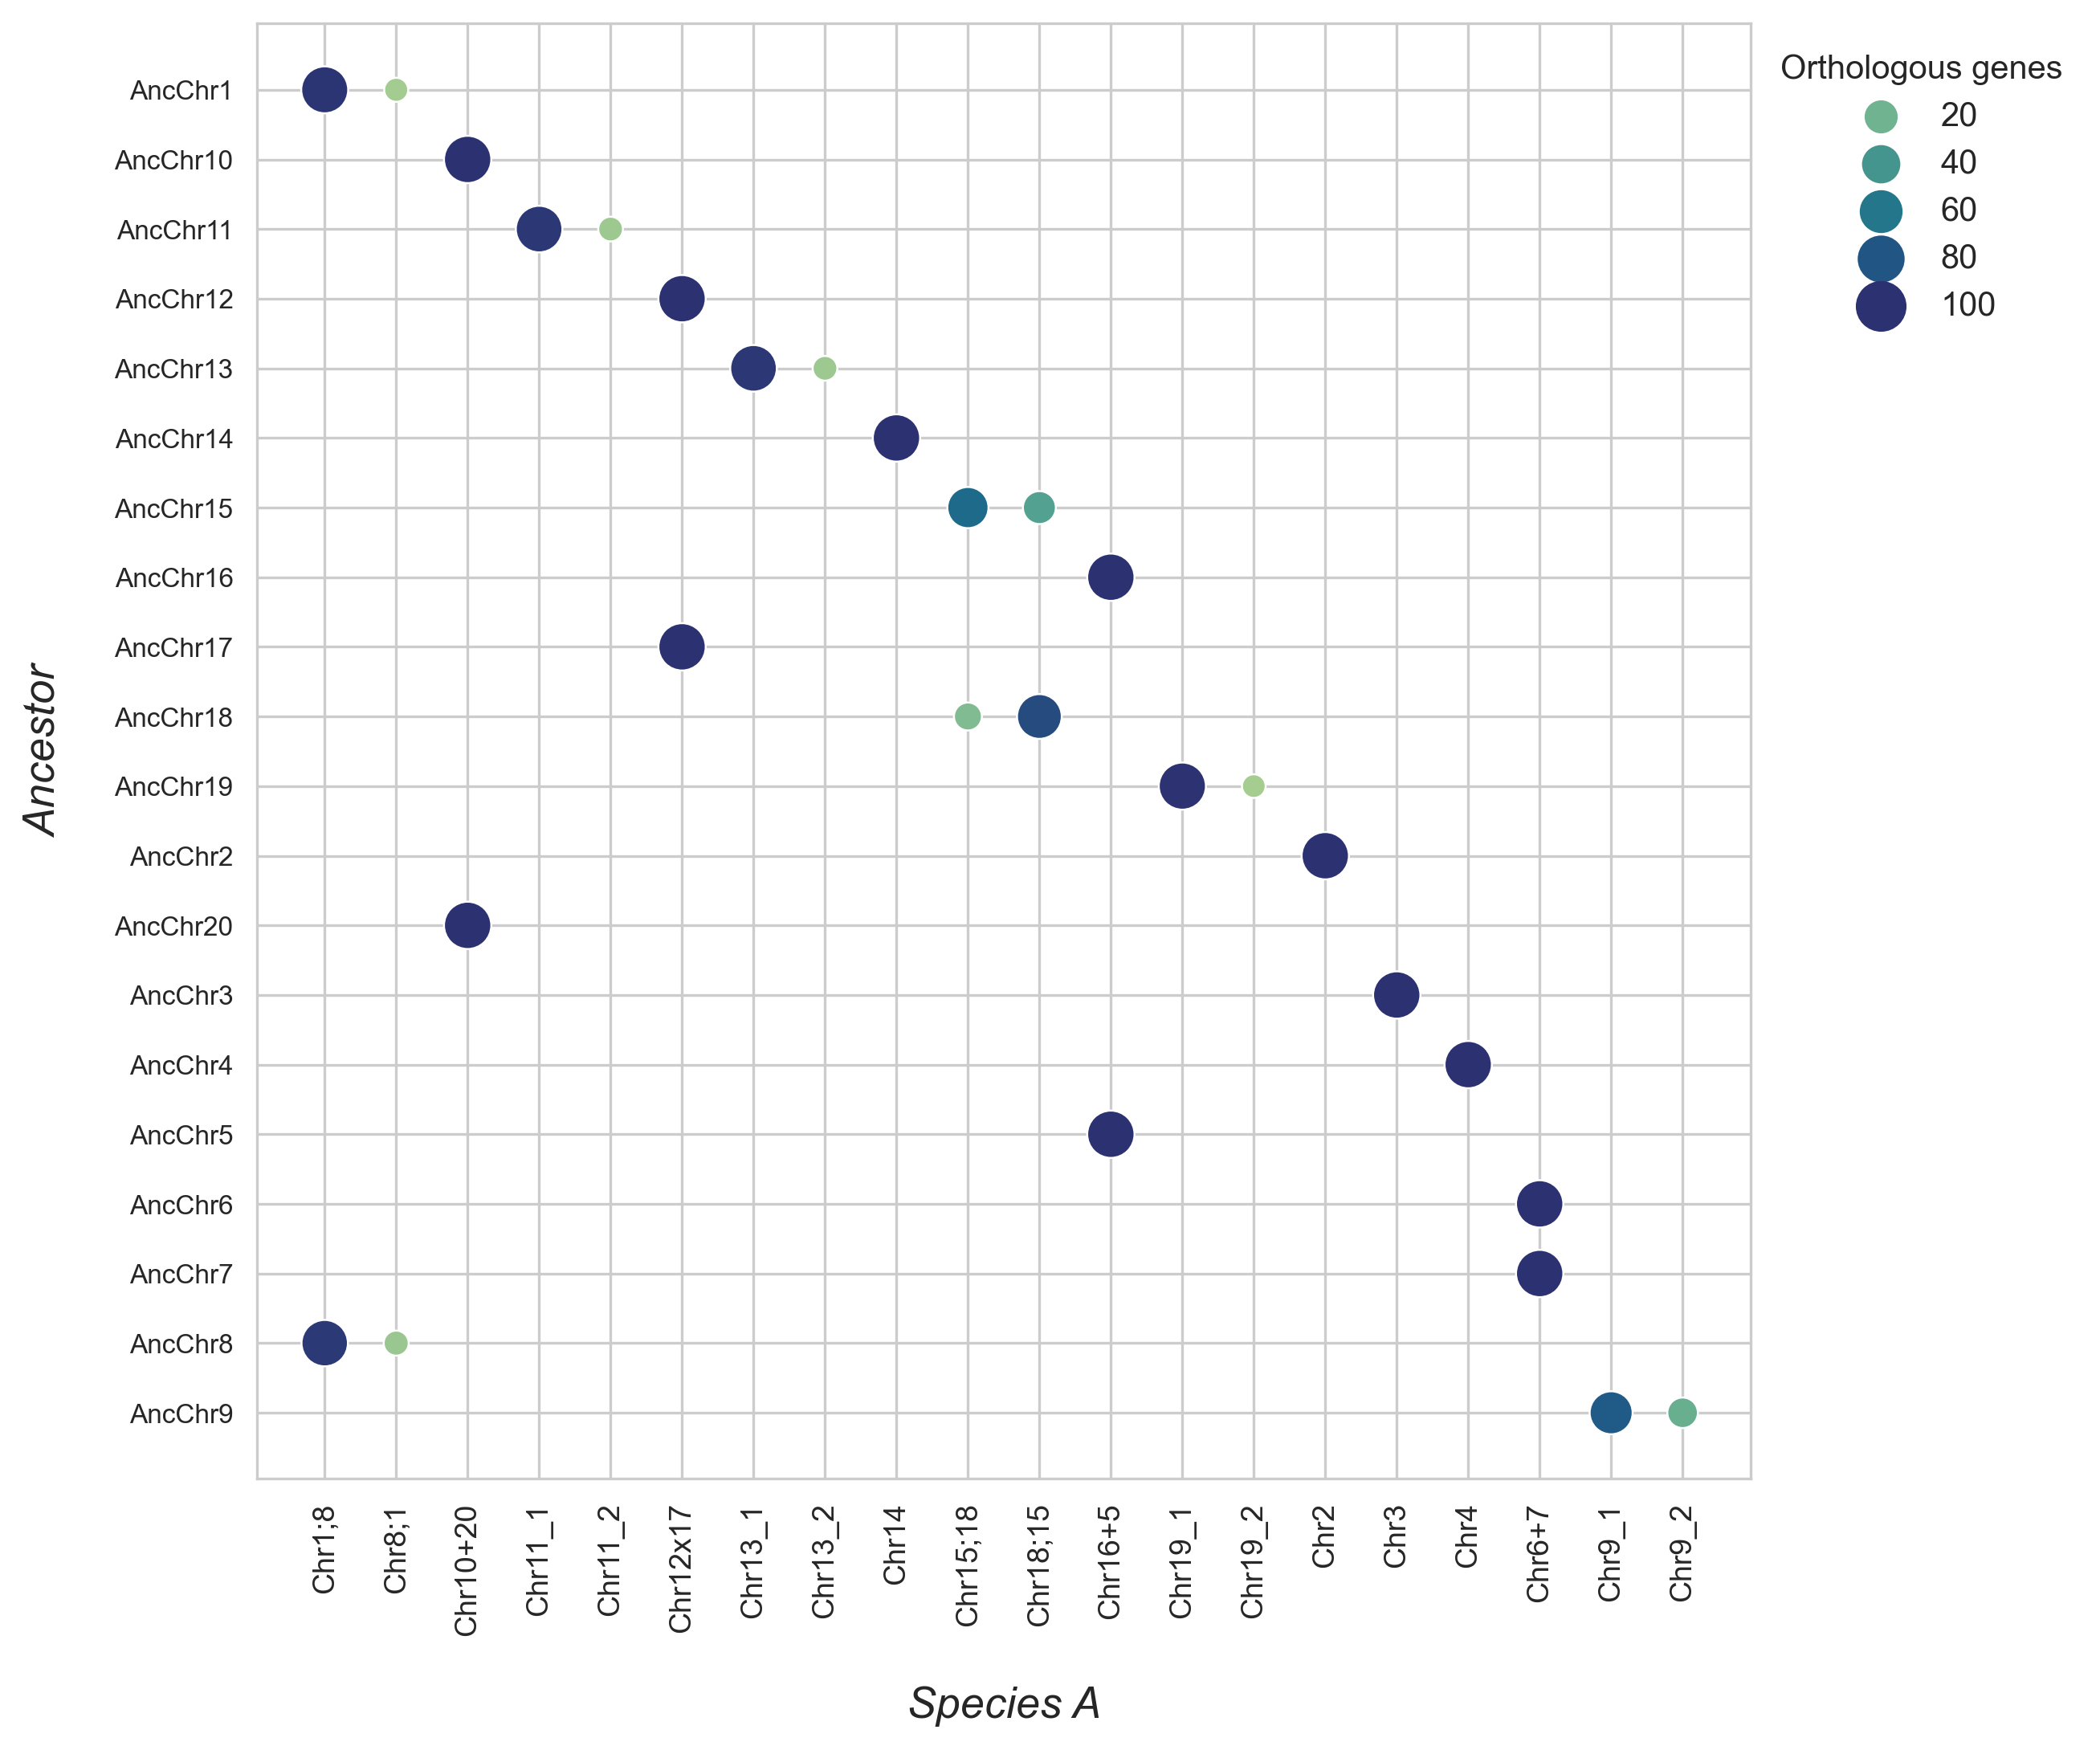

In [11]:
# Import 
anc = Orthoscripts.readBED("Simulations/Ancestor.genelist.bed", 's')
spA = Orthoscripts.readBED("Simulations/SpeciesA.genelist.bed", 's')
orth = np.loadtxt("Simulations/Ancestor+SpeciesA.txt", dtype = "str")

sim = Orthoscripts.orthologies(anc, spA, orth)

Orthoscripts.orthoplot(sim, 'Species A', 'Ancestor', 'B', 'A')

In [12]:
Orthoscripts.rearrangements(sim)

Fission of ancestral chromosome AncChr11 into Chr11_1, Chr11_2
Fission of ancestral chromosome AncChr13 into Chr13_1, Chr13_2
Fission of ancestral chromosome AncChr19 into Chr19_1, Chr19_2
Fission of ancestral chromosome AncChr9 into Chr9_1, Chr9_2
Fusion of ancestral chromosomes AncChr10, AncChr20 into Chr10+20
Fusion of ancestral chromosomes AncChr12, AncChr17 into Chr12x17
Fusion of ancestral chromosomes AncChr16, AncChr5 into Chr16+5
Fusion of ancestral chromosomes AncChr6, AncChr7 into Chr6+7
Translocation of ancestral chromosomes AncChr1, AncChr8 into Chr1;8, Chr8;1
Translocation of ancestral chromosomes AncChr15, AncChr18 into Chr15;18, Chr18;15
